In [1]:
# https://stackoverflow.com/questions/54044958/reading-data-from-a-raw-vtk-vtu-file

def vtu_extract_element_connectivity(fname):
    
    """
    Loads a vtu file, extracts the "connectivity" field and
    converts the data into a NumPy array (int64).
    The element-vertex map is returned as a 2D ndarray.
    It is assumed that all cells are of the same VTK type.
    The "offset" field in the vtu file is processed and checked to ensure that 
    all cells are the same VTK type (e.g. triangle).
    
    Parameters:
    -----------
    fname : string
      Filename of a VTU file      
    Returns:
    --------
    elmap : ndarray, shape = (ncells, npoints_per_cell)
        Element-vertex map associated with VTK cells, with dimensions (nCells, npoints_per_cell)
    """  
    import vtk as vtk

    # Read the source vtu file.
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(fname)
    reader.Update() # Needed because of GetScalarRange
    output = reader.GetOutput()

    cells = output.GetCells()

    offset_per_cell = cells.IsHomogeneous()
    if offset_per_cell <= 0:
        raise ValueError('Require all cells have the same size (homogeneous).')

    nCells = cells.GetNumberOfCells()
    array = cells.GetConnectivityArray()
    elmap = np.asarray(array ,dtype=np.int64)
    elmap = elmap.reshape(nCells, offset_per_cell)
    return elmap

In [2]:
def vtu_extract_fields(fname, extract_coor=True):
    """
    Extract point fields, cell fields and point coordiantes from a vtu file.
    
    Parameters:
    -----------
    extract_coor : boolean
        Flag to indicate whether you want the coordinates to be extracted.
    
    Returns:
    --------
    point_field : dict
      All point fields found. Key is the name provided in the VTU file.
    cell_field : dict
      All cell fields found. Key is the name provided in the VTU file.
    coor_field : dict
      Coordinates of the mesh. `coor_field` be empty if extract_coor = False.
      Key used is "coor".
    """
    
    import vtk as vtk
    
    point_field = {}
    cell_field = {}
    coor_field = {}
    
    # Read the source vtu file.
    reader = vtk.vtkXMLUnstructuredGridReader()
    reader.SetFileName(fname)
    reader.Update() # Needed because of GetScalarRange
    output = reader.GetOutput()

    points = output.GetPoints()
    array = points.GetData()
    xyz = np.asarray(array, dtype=np.float64)
    if extract_coor:
        coor_field["coor"] = xyz
    
    pointFields = output.GetPointData()
    
    nfields = pointFields.GetNumberOfArrays()
    print('#point fields', nfields)
    for f in range(nfields):
        print('  pointFields.name', pointFields.GetArrayName(f))
        #print('pointFields.ndof', pointFields.GetNumberOfComponents(f))
        array = pointFields.GetArray(f)
        pf = np.asarray(array, dtype=np.float64)
        point_field[ pointFields.GetArrayName(f) ] = pf
        
    #cells = output.GetCells()
    cellFields = output.GetCellData()
    nfields = cellFields.GetNumberOfArrays()
    print('#cell fields', nfields)
    for f in range(nfields):
        print('  cellFields.name', cellFields.GetArrayName(f))
        array = cellFields.GetArray(f)
        cf = np.asarray(array, dtype=np.float64)
        cell_field[ cellFields.GetArrayName(f) ] = cf
        
    return point_field, cell_field, coor_field

In [3]:
import numpy as np
e2v = vtu_extract_element_connectivity("stress000000.vtu")
pf, cf, coor = vtu_extract_fields("stress000000.vtu")

# See what we got
pf_names = list(pf.keys())
print('point fields found:', pf_names)
cf_names = list(cf.keys())
print('cell fields found:', cf_names)

#point fields 1
  pointFields.name f_50
#cell fields 0
point fields found: ['f_50']
cell fields found: []


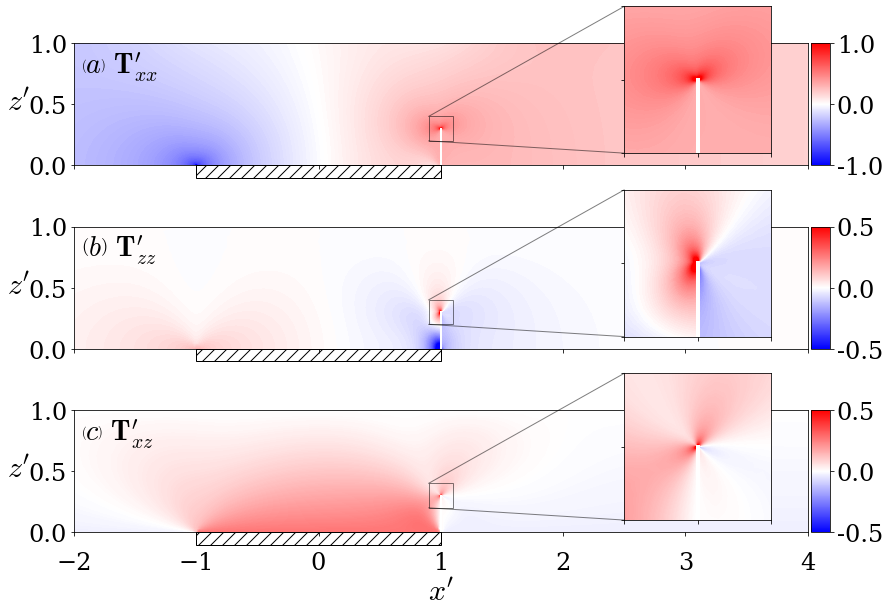

In [6]:
# This block of code is used to plot perturbation stress

import matplotlib.tri as mtri
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle

panel_font=28
cindex = 3
w=1.0
C =0.3
# Zoom in window range
x1, x2, y1, y2 = 0.9, 1.1, 0.2, 0.4

plt.rc('font', family='serif')
mpl.rcParams["mathtext.fontset"]='cm'
plt.rcParams['figure.figsize'] = (15.0, 9.0)
fs=24
########################### Figure 1 ################################
ax1 = plt.subplot(311)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

ax1 = plt.gca()
# ax1.set_xlabel(r'$x$',fontsize=22)
ax1.set_ylabel(r'$z^{\prime}$',rotation=0,fontsize=fs+6,loc='center')
ax1.set_xlim([-5, 5])
ax1.set_aspect('equal')
ax1.yaxis.set_label_coords(-0.075, 0.4)
plt.setp(ax1.get_xticklabels(), visible=False)

# plt.title(r'$\sigma_{xx}$ when $w=1$, $c=0.5$, $f=0.7$', fontsize=16, color='k')
plt.annotate(r'$\left(a\right)\ \mathbf{T}_{xx}^{\prime}$', xy=(0.01, 0.75), xycoords='axes fraction',fontsize=panel_font)
# crack
plt.plot([w,w],[0,C], color='white', linewidth=2)

# \sigma_{xx}
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cmap = mpl.cm.bwr
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v)
cfill = plt.tricontourf(tri, pf[pf_names[0]][:,0], levels=1000, cmap=cmap, norm=norm)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, format="%2.1f")

#### Zoom in axes in subplot 1
axins1 = ax1.inset_axes([0.75, 0.1, 0.2, 1.2])
axins1.set_xlim(x1, x2)
axins1.set_ylim(y1, y2)
plt.setp(axins1.get_xticklabels(), visible=False)
plt.setp(axins1.get_yticklabels(), visible=False)
ax1.indicate_inset_zoom(axins1, edgecolor="black")
axins1.plot([w,w],[0,C], color='white', linewidth=4)

cfill1 = axins1.tricontourf(tri, pf[pf_names[0]][:,0], levels=1000, cmap=cmap, norm=norm)

#### Sticky patch
ax1.add_patch(Rectangle((-1, -0.1), 2, 0.1, fill=False, hatch='//',clip_on=False))

########################### Figure 2 ################################
ax2 = plt.subplot(312, sharex=ax1)
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)

ax2 = plt.gca()
# ax1.set_xlabel(r'$x$',fontsize=22)
ax2.set_ylabel(r'$z^{\prime}$',rotation=0,fontsize=fs+6,loc='center')
ax2.set_xlim([-5, 5])
ax2.set_aspect('equal')
ax2.yaxis.set_label_coords(-0.075, 0.4)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.annotate(r'$\left(b\right)\ \mathbf{T}_{zz}^{\prime}$', xy=(0.01, 0.75), xycoords='axes fraction',fontsize=panel_font)
# crack
plt.plot([w,w],[0,C], color='white', linewidth=2)

norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)
cmap = mpl.cm.bwr
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v)
cfill = plt.tricontourf(tri, pf[pf_names[0]][:,4], levels=1000, cmap=cmap, norm=norm)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, format="%2.1f")

#### Zoom in axes in subplot 2
axins2 = ax2.inset_axes([0.75, 0.1, 0.2, 1.2])
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)
plt.setp(axins2.get_xticklabels(), visible=False)
plt.setp(axins2.get_yticklabels(), visible=False)
ax2.indicate_inset_zoom(axins2, edgecolor="black")
axins2.plot([w,w],[0,C], color='white', linewidth=4)

cfill2 = axins2.tricontourf(tri, pf[pf_names[0]][:,4], levels=1000, cmap=cmap, norm=norm)

#### Sticky patch
ax2.add_patch(Rectangle((-1, -0.1), 2, 0.1, fill=False, hatch='//',clip_on=False))

########################### Figure 3 ################################
ax3 = plt.subplot(313, sharex=ax1)

mpl.rcParams["mathtext.fontset"]='cm' 
plt.rc('xtick', labelsize=fs)
plt.rc('ytick', labelsize=fs)
plt.rc('axes', labelsize=fs)
ax3 = plt.gca()
ax3.set_xlabel(r'$x^{\prime}$',fontsize=fs+6)
ax3.set_ylabel(r'$z^{\prime}$',rotation=0,fontsize=fs+6)
#ylabel3=ax3.get_ylabel()
#ax3.set_position(ylabel3,-0.05,0.5)
ax3.yaxis.set_label_coords(-0.075, 0.4)

ax3.set_aspect('equal')
ax3.set_xlim([-2, 4])
ax3.tick_params(axis='x', which='major', pad=15)

# ax.set_title(r'$s(t) = \mathcal{A}\mathrm{sin}(2 \omega t)$', fontsize=16, color='k')
plt.annotate(r'$\left(c\right)\ \mathbf{T}_{xz}^{\prime}$', xy=(0.01, 0.75), xycoords='axes fraction',fontsize=panel_font)
# crack
plt.plot([w,w],[0,C], color='white', linewidth=2)

norm = mpl.colors.Normalize(vmin=-0.5, vmax=0.5)
cmap = mpl.cm.bwr
tri = mtri.Triangulation(coor['coor'][:, 0], coor['coor'][:, 1], e2v)
cfill = plt.tricontourf(tri, pf[pf_names[0]][:,1], levels=1000, cmap=cmap, norm=norm)

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2.5%", pad=0.05)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, format="%2.1f")

#### Zoom in axes in subplot 3
axins3 = ax3.inset_axes([0.75, 0.1, 0.2, 1.2])
axins3.set_xlim(x1, x2)
axins3.set_ylim(y1, y2)
plt.setp(axins3.get_xticklabels(), visible=False)
plt.setp(axins3.get_yticklabels(), visible=False)
ax3.indicate_inset_zoom(axins3, edgecolor="black")
axins3.plot([w,w],[0,C], color='white', linewidth=4)

cfill3 = axins3.tricontourf(tri, pf[pf_names[0]][:,1], levels=1000, cmap=cmap, norm=norm)

#### Sticky patch
ax3.add_patch(Rectangle((-1, -0.1), 2, 0.1, fill=False, hatch='//',clip_on=False))

# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('sigmap_C_zoom_'+str(cindex)+'.png', bbox_inches='tight', dpi=100)